<a href="https://colab.research.google.com/github/noussayma/ml-student/blob/main/BE_session1_probleme2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problème: un VIT pour du denoising

Depuis 2017, les **transformers** ont gagné en popularité. Ces réseaux de neurones très performants font intervenir un type de couche qui n'a pas été décrit en TP: la couche "attentionnelle". Ce problème présente un VIsual Transformer (VIT) très simple.

Pour entraîner notre premier transformer, nous reprenons le contexte d'une tâche de denoising (TP3). Les lignes de code suivantes permettent de visualiser les entrées et les cibles:

In [1]:
import os

In [2]:
! wget https://www.grosfichiers.com/mfh8gy5ZmfB_zaQP9HZKdDk
! mv mfh8gy5ZmfB_zaQP9HZKdDk utile_BE.py

from utile_BE import *

--2024-01-12 15:23:28--  https://www.grosfichiers.com/mfh8gy5ZmfB_zaQP9HZKdDk
Resolving www.grosfichiers.com (www.grosfichiers.com)... 51.68.254.173
Connecting to www.grosfichiers.com (www.grosfichiers.com)|51.68.254.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21240 (21K) [application/octet-stream]
Saving to: ‘mfh8gy5ZmfB_zaQP9HZKdDk’

mfh8gy5ZmfB_zaQP9HZ 100%[===================>]  20.74K  --.-KB/s    in 0s      

2024-01-12 15:23:29 (283 MB/s) - ‘mfh8gy5ZmfB_zaQP9HZKdDk’ saved [21240/21240]



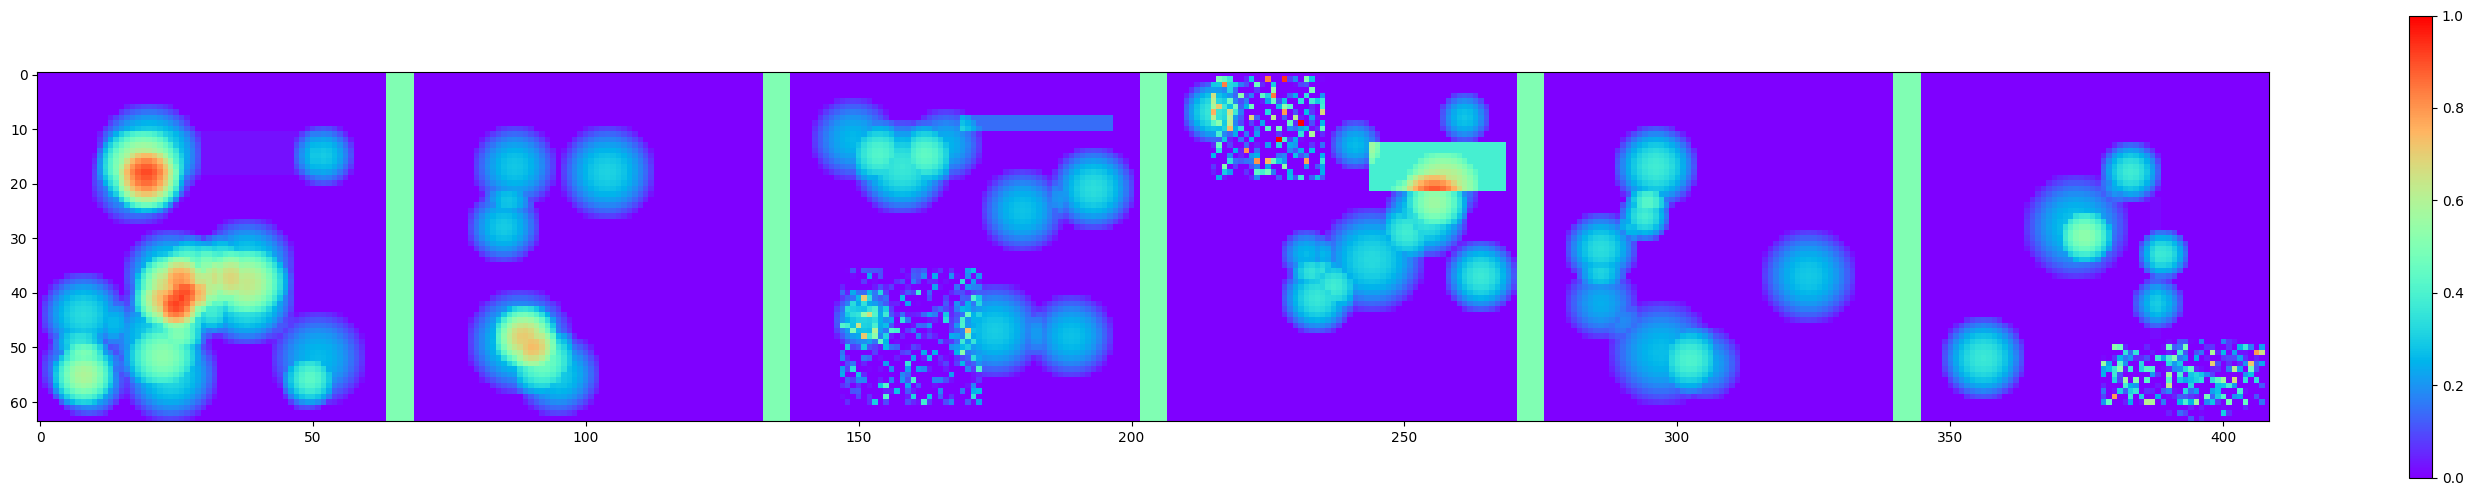

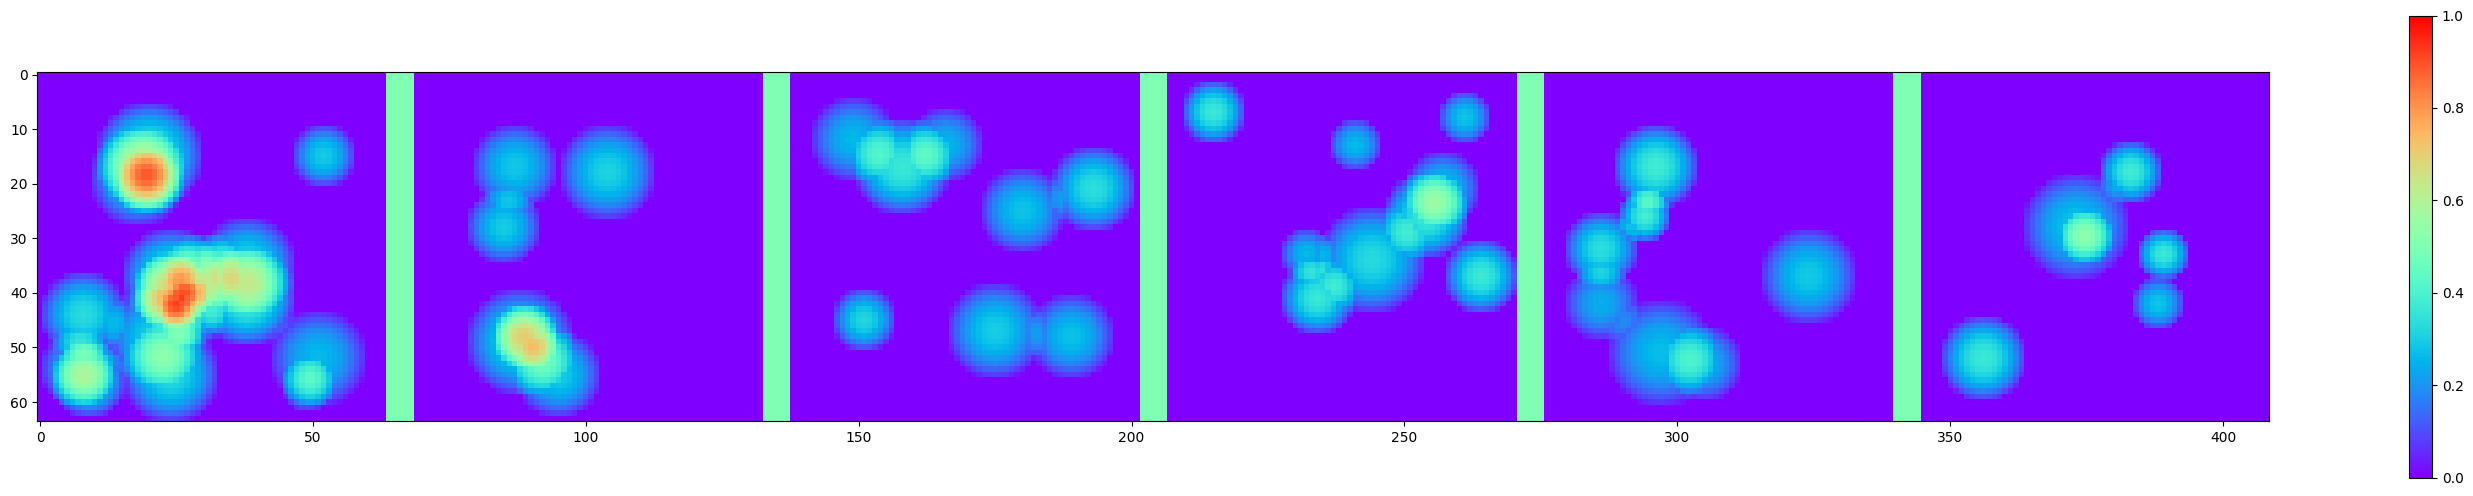

In [3]:
input, target = gen(6)

#versions bruitées (rectangles pleins et bruités)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

#versions propres (cellules seules)
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig1, k=0, min_scale=0,max_scale=1)

Maintenant, chargeons les bibliothèques/fonctions utiles. Pour information, **timm** contient les briques de base qui permettent de coder/d'entraîner/de fine tuner la plupart des modèles récents, et en particulier les transformers (ViT, DEiT, BEiT, etc).

In [4]:
! pip install timm
! pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 832.3 kB/s eta 0:00:00


In [5]:
import torch
import torch.nn as nn
from functools import partial
from timm.models.layers import trunc_normal_
import torch.nn.functional as F

# Pour initialiser les poids:
def init_weights(m):
    if isinstance(m, nn.Linear):
        trunc_normal_(m.weight, std=0.02)
        if isinstance(m, nn.Linear) and m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.bias, 0)
        nn.init.constant_(m.weight, 1.0)

Le "transformer" a été conçu pour une tâche de traduction de texte. Il opère donc sur une séquence de mots.\
Le "vision transformer" est une adaptation du transformer à des tâches de vision par ordinateur. Cette adaptation est fondée sur un découpage de l'image d'entrée en imagettes ("patchs").
Chaque patch est alors traité comme un caractère musical dans le TP 4 partie 2: il est projeté dans un espace de représentation propre au modèle.

Les hyperparamètres ci-dessous précisent, entre autres, les caractéristiques de l'image d'entrée, la taille des patchs (8 x 8), le nombre de dimensions de l'espace de représentation ("d_model").\
Le sens des autres hyperparamètres sera donné au fil de l'énoncé.


In [6]:
image_size = [64,64]
channels = 1
patch_size = 8
d_model = 32
mlp_expansion_ratio = 4
d_ff = mlp_expansion_ratio * d_model
n_heads = 4
n_layers = 12

## **A.** Projection dans l'espace de représentation (Embedding)

**Q1** Préciser la forme (.shape) du tenseur d'entrée (*input*).\
Que représente la première composante (chiffre 6) ?

In [8]:
input.shape

torch.Size([6, 1, 64, 64])

La premiere composante 6 represente la taille du batch : batch_size

**Q2** La classe *PatchEmbedding* suivante permet de découper une image en patchs et projeter les patchs dans un epace de dimension donnée par la variable *d_model*.
L'instancier avec les hyperparamètres précédents.  
L'appliquer au tenseur *input* et stocker le résultat dans la variable *x*.

In [7]:
class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, d_model, channels):
        super().__init__()

        self.image_size = image_size
        if image_size[0] % patch_size != 0 or image_size[1] % patch_size != 0:
            raise ValueError("image dimensions must be divisible by the patch size")
        self.grid_size = image_size[0] // patch_size, image_size[1] // patch_size
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.patch_size = patch_size

        self.proj = nn.Conv2d(
            channels, d_model, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, im):
        B, C, H, W = im.shape
        x = self.proj(im).flatten(2).transpose(1, 2)
        return x


In [9]:


patch_embed = PatchEmbedding(image_size, patch_size, d_model, channels)
x = patch_embed(input)

**Q3** Préciser la forme du tenseur *x*. Pourquoi la seconde composante vaut-elle 64 ?


In [11]:
x.shape

torch.Size([6, 64, 32])

La deuxième composante de la forme du tenseur  vaut 64 parce qu'elle représente le nombre de patchs extraits de l'image d'entrée.

 Cette valeur est calculée en divisant la hauteur et largeur totales de l'image par la taille des patchs. 64/8 = 8

64 = 8 * 8


**Q4** : l'objet *embed* contient-il des paramètres entraînables ? Quel type de couche de neurones est employé ici ? Préciser le rôle du paramètre *stride* dans le "découpage" de l'imagette.

Oui, l'objet embed contient des paramètres entraînables. Il utilise une couche de neurones de type nn.Conv2d

In [12]:
# Pour voir les noms des couches contenues dans UNEt
for module in patch_embed.modules():
    print(module.__class__.__name__)

PatchEmbedding
Conv2d


Le paramètre stride dans la couche nn.Conv2d contrôle le décalage entre les positions où la convolution est appliquée lors du découpage de l'imagette en patchs. Plus précisément, il détermine le nombre de pixels sautés à chaque étape lors de la convolution.

Dans cette opération de découpage, l'information sur la position relative des patchs dans l'image est partiellement perdue. Pour compenser cette perte, on associe à chacune des positions possibles un vecteur de l'espace des représentations (tokénisation). On ajoute ces vecteurs aux projections.\
Ceci se traduit par l'opération suivante:

In [13]:
pos_embed = nn.Parameter(torch.randn(1, patch_embed.num_patches, d_model))

x = x + pos_embed

**Q5** A ce stade, combien le réseau compte-t-il de paramètres entraînables ?

À ce stade, le réseau compte n​ paramètres entraînables supplémentaires pour les vecteurs de position pos_embed associés à chaque position possible des patchs dans l'image x.

L'introduction de pos_embed conduit a n​×num_patches param supplémentaires

Le tenseur *x* est ensuite passé à travers une série de blocs identiques (*n_layers* représente le nombre de blocs).\
Chaque bloc est constitué, dans l'ordre :
- d'une opération de normalisation particulière (nous n'en discuterons pas ici)
- d'une couche "attentionnelle"
- d'une couche nommée "FeedForward".

Voyons d'abord **la couche attentionnelle**.

## **B.** La couche attentionnelle

L'idée de base est simple : pour "comprendre" le contenu d'un patch, il n'est pas nécessaire de consulter tous les autres patches, mais seulement certains d'entre eux. En d'autre termes, il faut prêter "attention"  aux patchs pertinents.\
La couche attentionnelle encode un mécanisme de sélection des patchs les plus pertinents. Notez qu'elle opère non directement sur les patchs, mais sur les **vecteurs** auxquels ils ont été associés via l'étape d'embedding (les vecteurs contenus dans *x*).  

Précisément, une couche attentionnelle "simple" contient les opérations suivantes:
- une première application linéaire projette un **vecteur** d'entrée vers trois vecteurs : le premier est appelé "requête" (query), le second "clef" (key) et le troisième "valeur" (value).
- pour chaque patch $i$, on évalue la "pertinence" du patch $j$ par le produit scalaire entre la requête $q_i$ associée au patch $i$ et la clef $k_j$ associée au patch $j$. Une opération de normalisation propre à la couche attentionnelle est appliquée à l'ensemble de ces produits scalaires.
- on associe alors au patch $i$ la somme des valeurs $v_j$ pondérées par ces produits scalaires normalisés.
- une seconde application linéaire transforme cette somme pondérée en le vecteur de sortie, de même dimension que le vecteur d'entrée.

Dernière subtilité: dans un VIT, ce sont des couches attentionnelles composées (multi-head attention) qui sont utilisées. Chaque "tête" correspond à une couche attentionnelle simple.
La classe ci-dessous code pour une couche attentionnelle composée :

In [14]:
class Attention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()

        # Nombre de "têtes"
        self.heads = n_heads

        # Taille des vecteurs requête, clefs, valeur
        self.head_dim = d_model // n_heads

        # Scalaire utilisé à l'étape de normalisation
        self.scale = self.head_dim ** -0.5

        # Première application linéaire
        self.qkv = nn.Linear(d_model, n_heads * self.head_dim * 3)

        # Seconde application linéaire
        self.proj = nn.Linear(n_heads * self.head_dim, d_model)


    def forward(self, x, mask=None):
        B, N, C = x.shape

        # Calcul des requêtes, clefs, valeurs
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.heads, self.head_dim)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = (
            qkv[0],
            qkv[1],
            qkv[2],
        )
        # Produits scalaires
        p = (q @ k.transpose(-2, -1))

        # A décommenter pour la question 10:
        # print(q.shape, k.transpose(-2, -1).shape)

        # Etape de normalisation
        p *= self.scale
        p = p.softmax(dim=-1)

        # Somme pondérée
        x = (p @ v).transpose(1, 2).reshape(B, N, C)

        # Sortie
        x = self.proj(x)

        return x

**Q6** Instancier la classe *Attention* et l'appliquer au tenseur *x*. Cette couche conserve-t-elle les dimensions du tenseur d'entrée ?

In [15]:
attn = Attention(d_model, n_heads)
x =  x = attn(x)

**Q7** Que représente le symbole @ pour des tenseurs **d'ordre supérieur à deux** selon la [PEP 465](https://peps.python.org/pep-0465/#:~:text=This%20PEP%20proposes%20the%20minimum,%2C%20and%20%40%20for%20matrix%20multiplication.) ?

Le symbole @ pour le stenseurs d'ordre supérieur a 2 signifie : l'opération de multiplication matricielle : * de la méthode __matmul__

**Q8** Une couche attentionnelle composée est-elle linéaire ?
Préciser de quelles opérations proviennent la non-linéarité.

Une couche attentionnelle composée n'est pas linéaire.Les non-linéarités proviennent de : Calcul des poids d'attention et Combinaison des valeurs

**Q9** Le nombre de poids dépend-il du nombre de têtes ? Justifier.

**Q10** Un nombre de tête plus élevé a-t-il un effet sur la complexité du calcul ? Répondre en considérant les calculs matriciels effectués pour différentes valeurs de *n_heads* (eg. décommenter le *print* dans la classe *Attention*).

## **C.** Définition d'un bloc

**Q11** Dans un bloc, la couche attentionnelle est suivie d'un réseau de la classe FeedForward (voir ci-dessous).
Comment appelle-t-on ce type de couche ?
Quelle est-ici la fonction d'activation ? La décrire en quelques mots.

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, out_dim=None):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.act = nn.GELU()
        if out_dim is None:
            out_dim = d_model
        self.fc2 = nn.Linear(d_ff, out_dim)

    def unwrapped(self):
        return self

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

**Q12** Appliquer un objet de cette classe à *x*. A quoi correspond le paramètre *d_ff* ?

In [ ]:
ff = ...

x = ...

Un bloc complet peut maintenant être défini. Il contient les deux couches précédentes et des opérations de normalisation paramétrables :

In [ ]:
class Block(nn.Module):
    def __init__(self, d_model, n_heads, d_ff):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.attn = Attention(d_model, n_heads)
        self.mlp = FeedForward(d_model, d_ff)


    def forward(self, x, mask=None, return_attention=False):
        #a modifier (voir question 14)
        y = self.attn(self.norm1(x), mask)
        y = self.mlp(self.norm2(y))

        return y

**Q13** Vérifier qu'une application successive de plusieurs blocs ne changera pas les dimensions du tenseur d'entrée.

In [ ]:
...

**Q14** Dans la figure *1* de l'[article qui définit les Visual Transformers](https://arxiv.org/pdf/2010.11929.pdf), le bloc correspond au rectangle gris à droite de la ligne pointillée verticale.
Compléter la méthode forward pour que la correspondance soit parfaite.

## **D.** Définition d'un Denoising-VIT :

Nous en savons assez pour définir une classe simple de transformers:

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        image_size,
        patch_size,
        n_layers,
        d_model,
        d_ff,
        n_heads,
        channels=1,
    ):
        super().__init__()
        self.patch_embed = PatchEmbedding(
            image_size,
            patch_size,
            d_model,
            channels,
        )
        self.patch_size = patch_size
        self.n_layers = n_layers
        self.d_model = d_model
        self.d_ff = d_ff
        self.n_heads = n_heads
        self.pos_embed = nn.Parameter(
                torch.randn(1, self.patch_embed.num_patches, d_model) # pas +1
            )
        trunc_normal_(self.pos_embed, std=0.02)

        self.blocks = nn.ModuleList(
            [Block(d_model, n_heads, d_ff) for i in range(n_layers)]
        )
        self.norm = nn.LayerNorm(d_model)

        self.apply(init_weights)



    def forward(self, im):
        # Embedding (à compléter):
        x = ...

        # Cascade de blocs (à compléter):
        for blk in self.blocks:
            ...

        # normalisation finale de l'encodeur:
        x = self.norm(x)

        return x


**Q15** Compléter la méthode forward de cette classe puis l'instancier avec les paramètres définis plus haut. S'assurer que le modèle instancié peut prendre entrée le batch généré au début du problème. Vérifier la forme du tenseur de sortie.

In [ ]:
...

print(encoder(input).shape)

Pour obtenir une prédiction à l'échelle du pixel, nous allons nous donner une classe de décodeurs (*Decoder*). La classe *Denoiser* qui la suit combine  l'encodeur et le décodeur :

In [ ]:
from einops import rearrange

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class Up0(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch, in_ch, kernel_size=2, stride=2)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1):
        x1 = self.up(x1)
        x = self.conv(x1)
        return x

class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class Decoder(nn.Module):
    """
    vaut uniquement si channels = 1 et image_size =64
    """
    def __init__(self, patch_size, d_model):
        super().__init__()

        self.d_model = d_model
        self.ps = patch_size

        self.head = nn.Linear(self.d_model, self.ps**2)
        self.apply(init_weights)
        self.up1 =  Up0(32, 16)
        self.up2 =  Up0(16, 8)
        self.up3 =  Up0(8, 4)
        self.outc = outconv(4, 1)

    def forward(self, x):

        x = rearrange(x, "b (h w) c -> b c h w", h=8)
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.outc(x)
        return x


In [ ]:
class Denoiser(nn.Module):
    def __init__(
        self,
        encoder,
        decoder,
    ):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder


    def forward(self, im):

        x = self.encoder(im)
        x = self.decoder(x)

        return x


**Q16** Quels sont les rôles de *nn.ConvTranspose2d* et de la fonction *rearrange* dans le code ? En quoi ce décodeur diffère-t-il de celui qu'on trouve dans un UNet ?

**Q17** Compléter la classe Decoder pour que la sortie du réseau ait la même taille que l'entrée.

**Q18** Instancier un Denoiser. Vérifier les dimensions en sortie de ce modèle.

**Q19** Combien un Denoiser compte-t-il de poids entraînables ?

## **E.** Entraînement d'un Denoising-VIT

**Q20** Entraîner le model sur carte GPU (30 époques, MSE, optimizer d'ADAM avec des paramètres standard). Visualiser la sortie et commenter.

In [ ]:
#visualization:

model.eval()

inputs, targets = gen(6)
inputs = inputs.to(device)
targets = targets.to(device)

outputs = model(inputs)
print(outputs.shape)
fig = plt.figure(0, figsize=(36, 6))  # first row: inputs
voir_batch2D(inputs.cpu(), 6, fig, k=0, min_scale=0, max_scale=1)
fig2 = plt.figure(1, figsize=(36, 6))  # second row: ground truth
voir_batch2D(targets.detach().cpu(), 6, fig2, k=0, min_scale=0, max_scale=1)
fig3 = plt.figure(2, figsize=(36, 6))  # last row: outputs
voir_batch2D(outputs.detach().cpu(), 6, fig2, k=0, min_scale=0, max_scale=1)